In [75]:
use_cuda = True
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")
import sys
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [76]:
use_cuda = True
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.harmonization.utils_chenling import CompareModels
import numpy as np
plotname = 'MarrowTM'

from scvi.dataset.muris_tabula import TabulaMuris
dataset1 = TabulaMuris('facs', save_path='/data/yosef2/scratch/chenling/scanvi_data/')
dataset2 = TabulaMuris('droplet', save_path='/data/yosef2/scratch/chenling/scanvi_data/')
dataset1.subsample_genes(dataset1.nb_genes)
dataset2.subsample_genes(dataset2.nb_genes)

gene_dataset = GeneExpressionDataset.concat_datasets(dataset1, dataset2)

File /data/yosef2/scratch/chenling/scanvi_data/TM_droplet_metadata.csv already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_facs_metadata.csv already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_droplet_mat.h5ad already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_facs_mat.h5ad already downloaded
True
File /data/yosef2/scratch/chenling/scanvi_data/TM_droplet_metadata.csv already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_facs_metadata.csv already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_droplet_mat.h5ad already downloaded
File /data/yosef2/scratch/chenling/scanvi_data/TM_facs_mat.h5ad already downloaded
Downsampling from 20508 to 17802 genes
Downsampling from 5351 to 5351 cells
Downsampling from 20508 to 14687 genes
Downsampling from 4112 to 4112 cells
Keeping 14590 genes


In [77]:
from scvi.harmonization.utils_chenling import SubsetGenes

In [78]:
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset, 'MarrowTM')

Downsampling from 17802 to 1804 genes
Downsampling from 5351 to 5351 cells
Downsampling from 14687 to 1804 genes
Downsampling from 4112 to 4112 cells
Downsampling from 14590 to 1804 genes
Downsampling from 9463 to 9463 cells


In [79]:
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

In [80]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='zinb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_zinb = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [05:22<00:00,  1.19it/s]


In [81]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='nb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_nb = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [06:06<00:00,  1.57s/it]


In [113]:
gene_dataset.n_labels

29

In [42]:
gene_dataset.X.shape

(9463, 1804)

In [43]:
cellsize = gene_dataset.X.mean(axis=1)

In [44]:
library_size_NB = full_nb.get_stats()

In [45]:
library_size_ZINB = full_zinb.get_stats()

In [46]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


In [47]:
cellsize = np.asarray(cellsize).ravel()

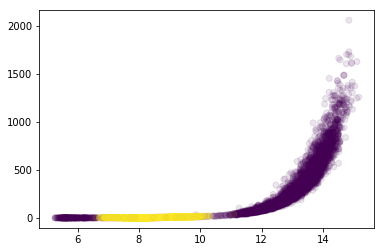

In [48]:
plt.scatter(library_size_NB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

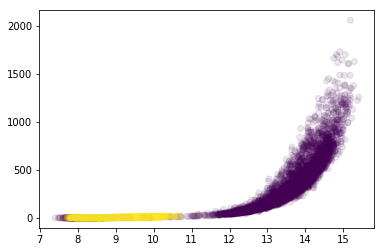

In [49]:
plt.scatter(library_size_ZINB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

In [50]:
from scipy.stats import spearmanr
spearmanr(library_size_ZINB,cellsize)

SpearmanrResult(correlation=0.9753143367536067, pvalue=0.0)

In [51]:
spearmanr(library_size_NB,cellsize)

SpearmanrResult(correlation=0.9718690802265432, pvalue=0.0)

In [52]:
mean_libsize = np.repeat(np.mean(np.unique(gene_dataset.local_means)), len(gene_dataset.local_means))
mean_libvar = np.repeat(np.mean(np.unique(gene_dataset.local_vars)), len(gene_dataset.local_means))

In [53]:
gene_dataset.local_means  = mean_libsize.astype(np.float32).reshape(len(mean_libsize),1)
gene_dataset.local_vars  = mean_libvar.astype(np.float32).reshape(len(mean_libsize),1)

In [54]:
gene_dataset.local_means 

array([[10.670719],
       [10.670719],
       [10.670719],
       ...,
       [10.670719],
       [10.670719],
       [10.670719]], dtype=float32)

In [55]:
gene_dataset.local_vars

array([[1.8989275],
       [1.8989275],
       [1.8989275],
       ...,
       [1.8989275],
       [1.8989275],
       [1.8989275]], dtype=float32)

In [56]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='zinb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_zinb2 = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [06:00<00:00,  1.18s/it]


In [57]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='nb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_nb2 = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [05:36<00:00,  1.64s/it]


In [58]:
library_size_NB = full_nb2.get_stats()
library_size_ZINB = full_zinb2.get_stats()

In [59]:
spearmanr(library_size_ZINB,cellsize)

SpearmanrResult(correlation=0.9716339685648248, pvalue=0.0)

In [60]:
spearmanr(library_size_NB,cellsize)

SpearmanrResult(correlation=0.965722098449007, pvalue=0.0)

In [61]:
from umap import UMAP

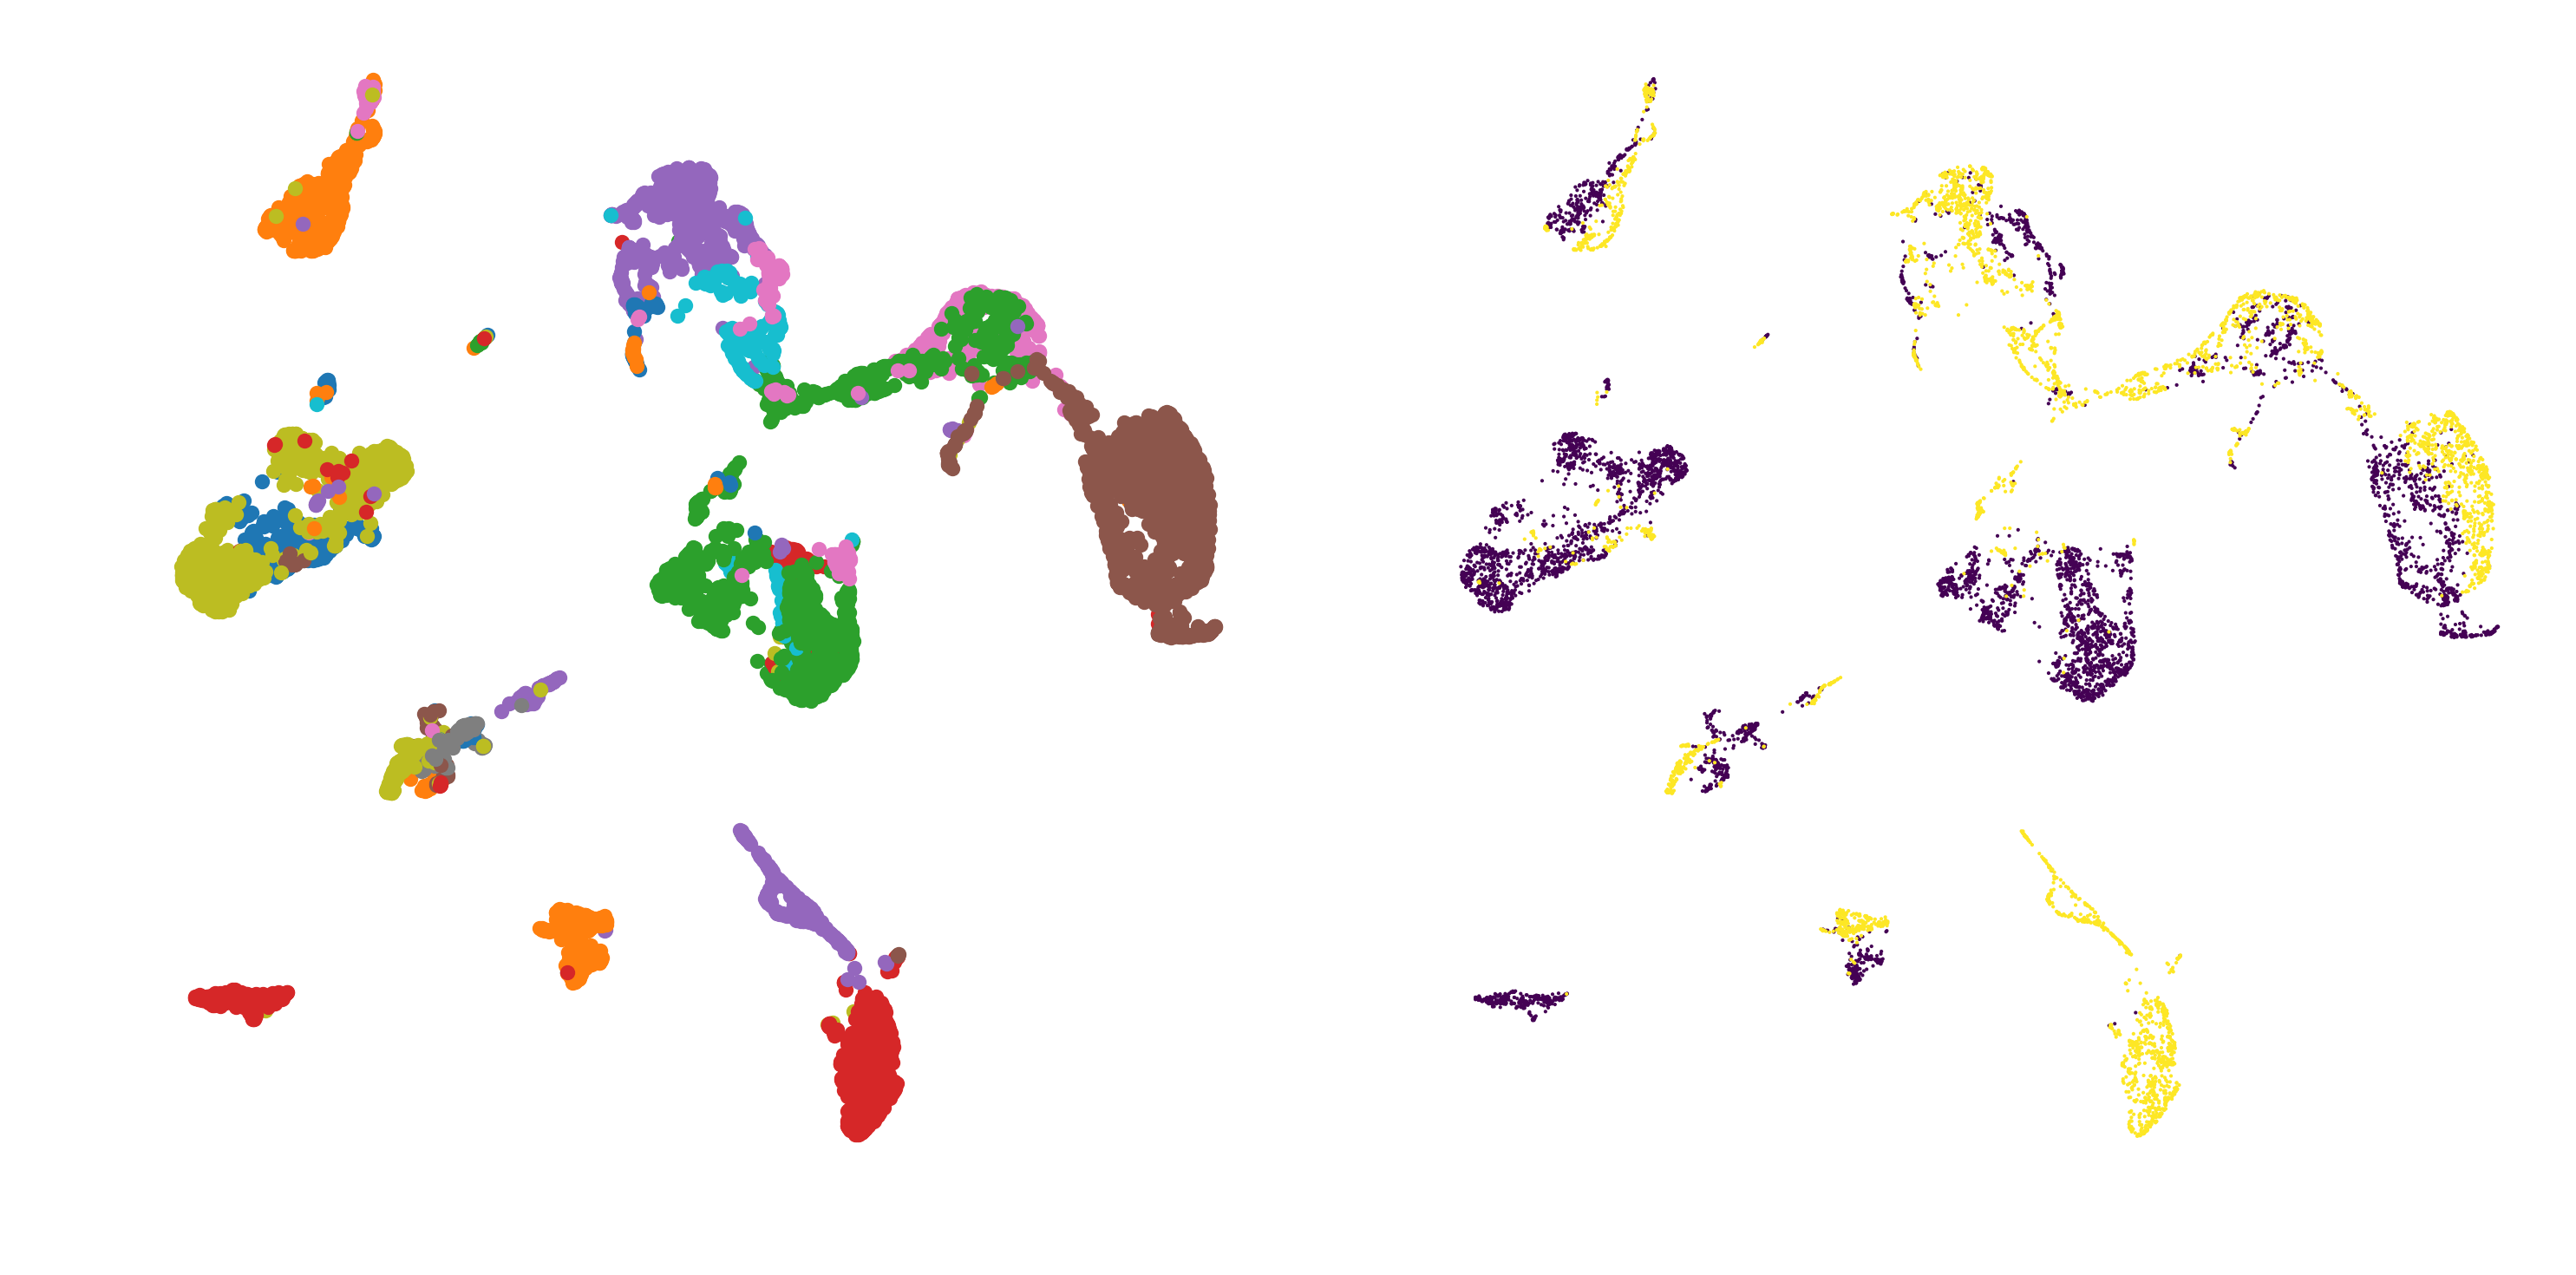

In [92]:
latent, batch_indices, labels = full_zinb2.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
# plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

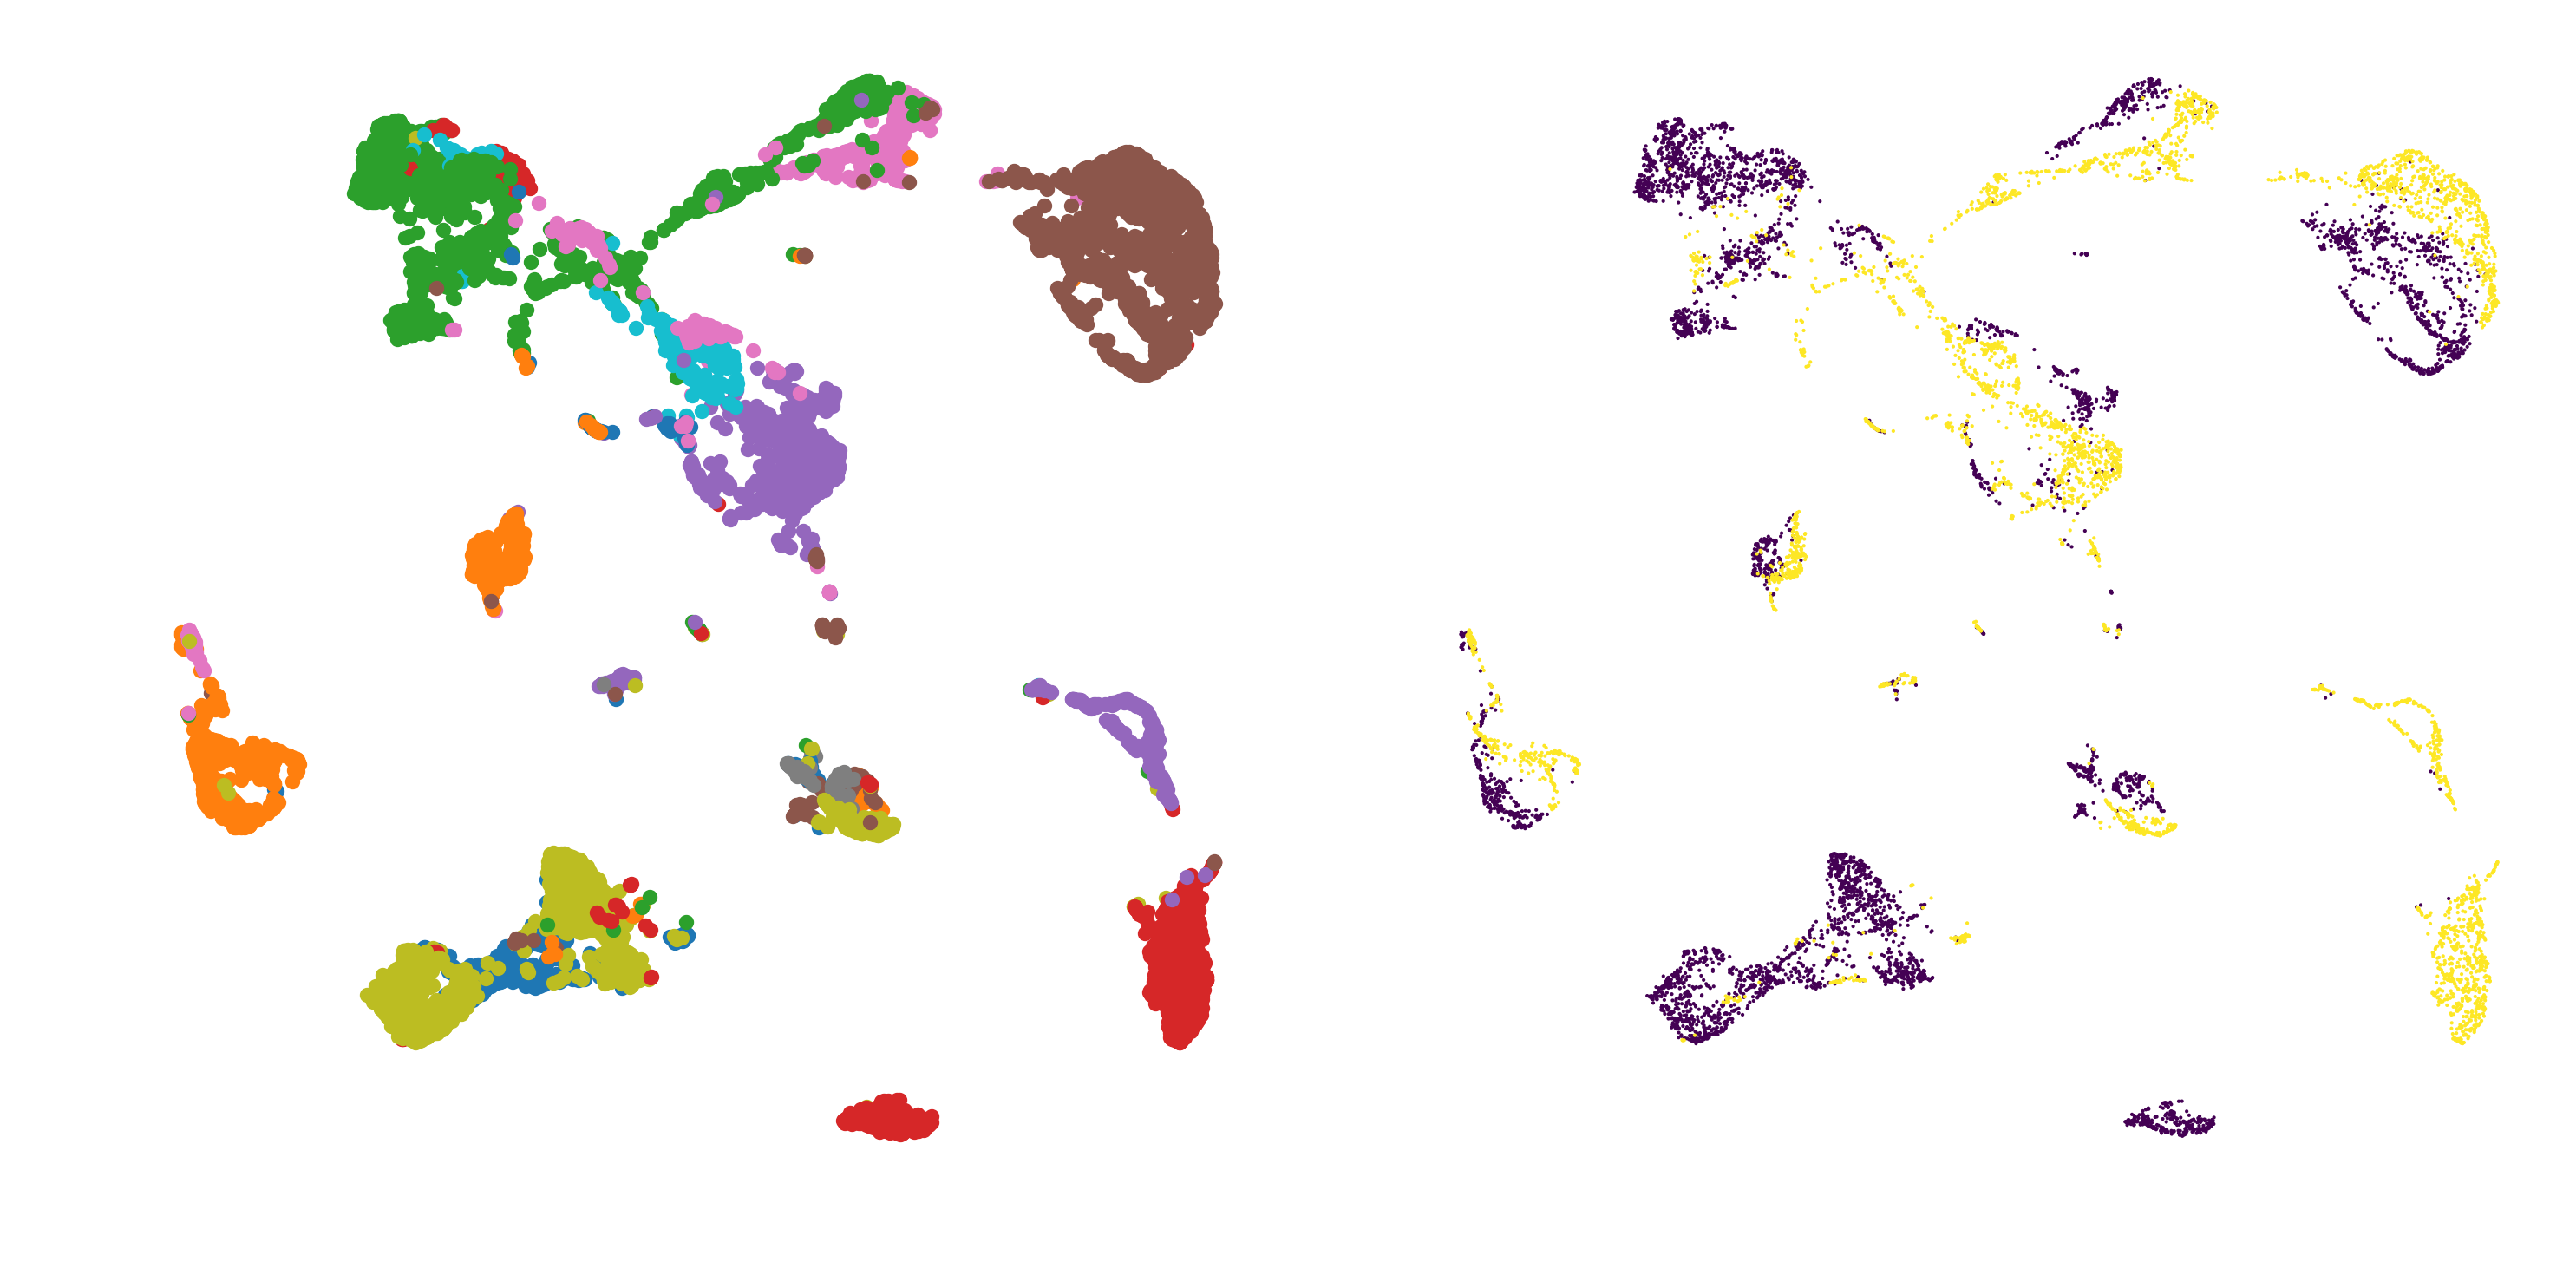

In [93]:
latent, batch_indices, labels = full_zinb.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
# plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

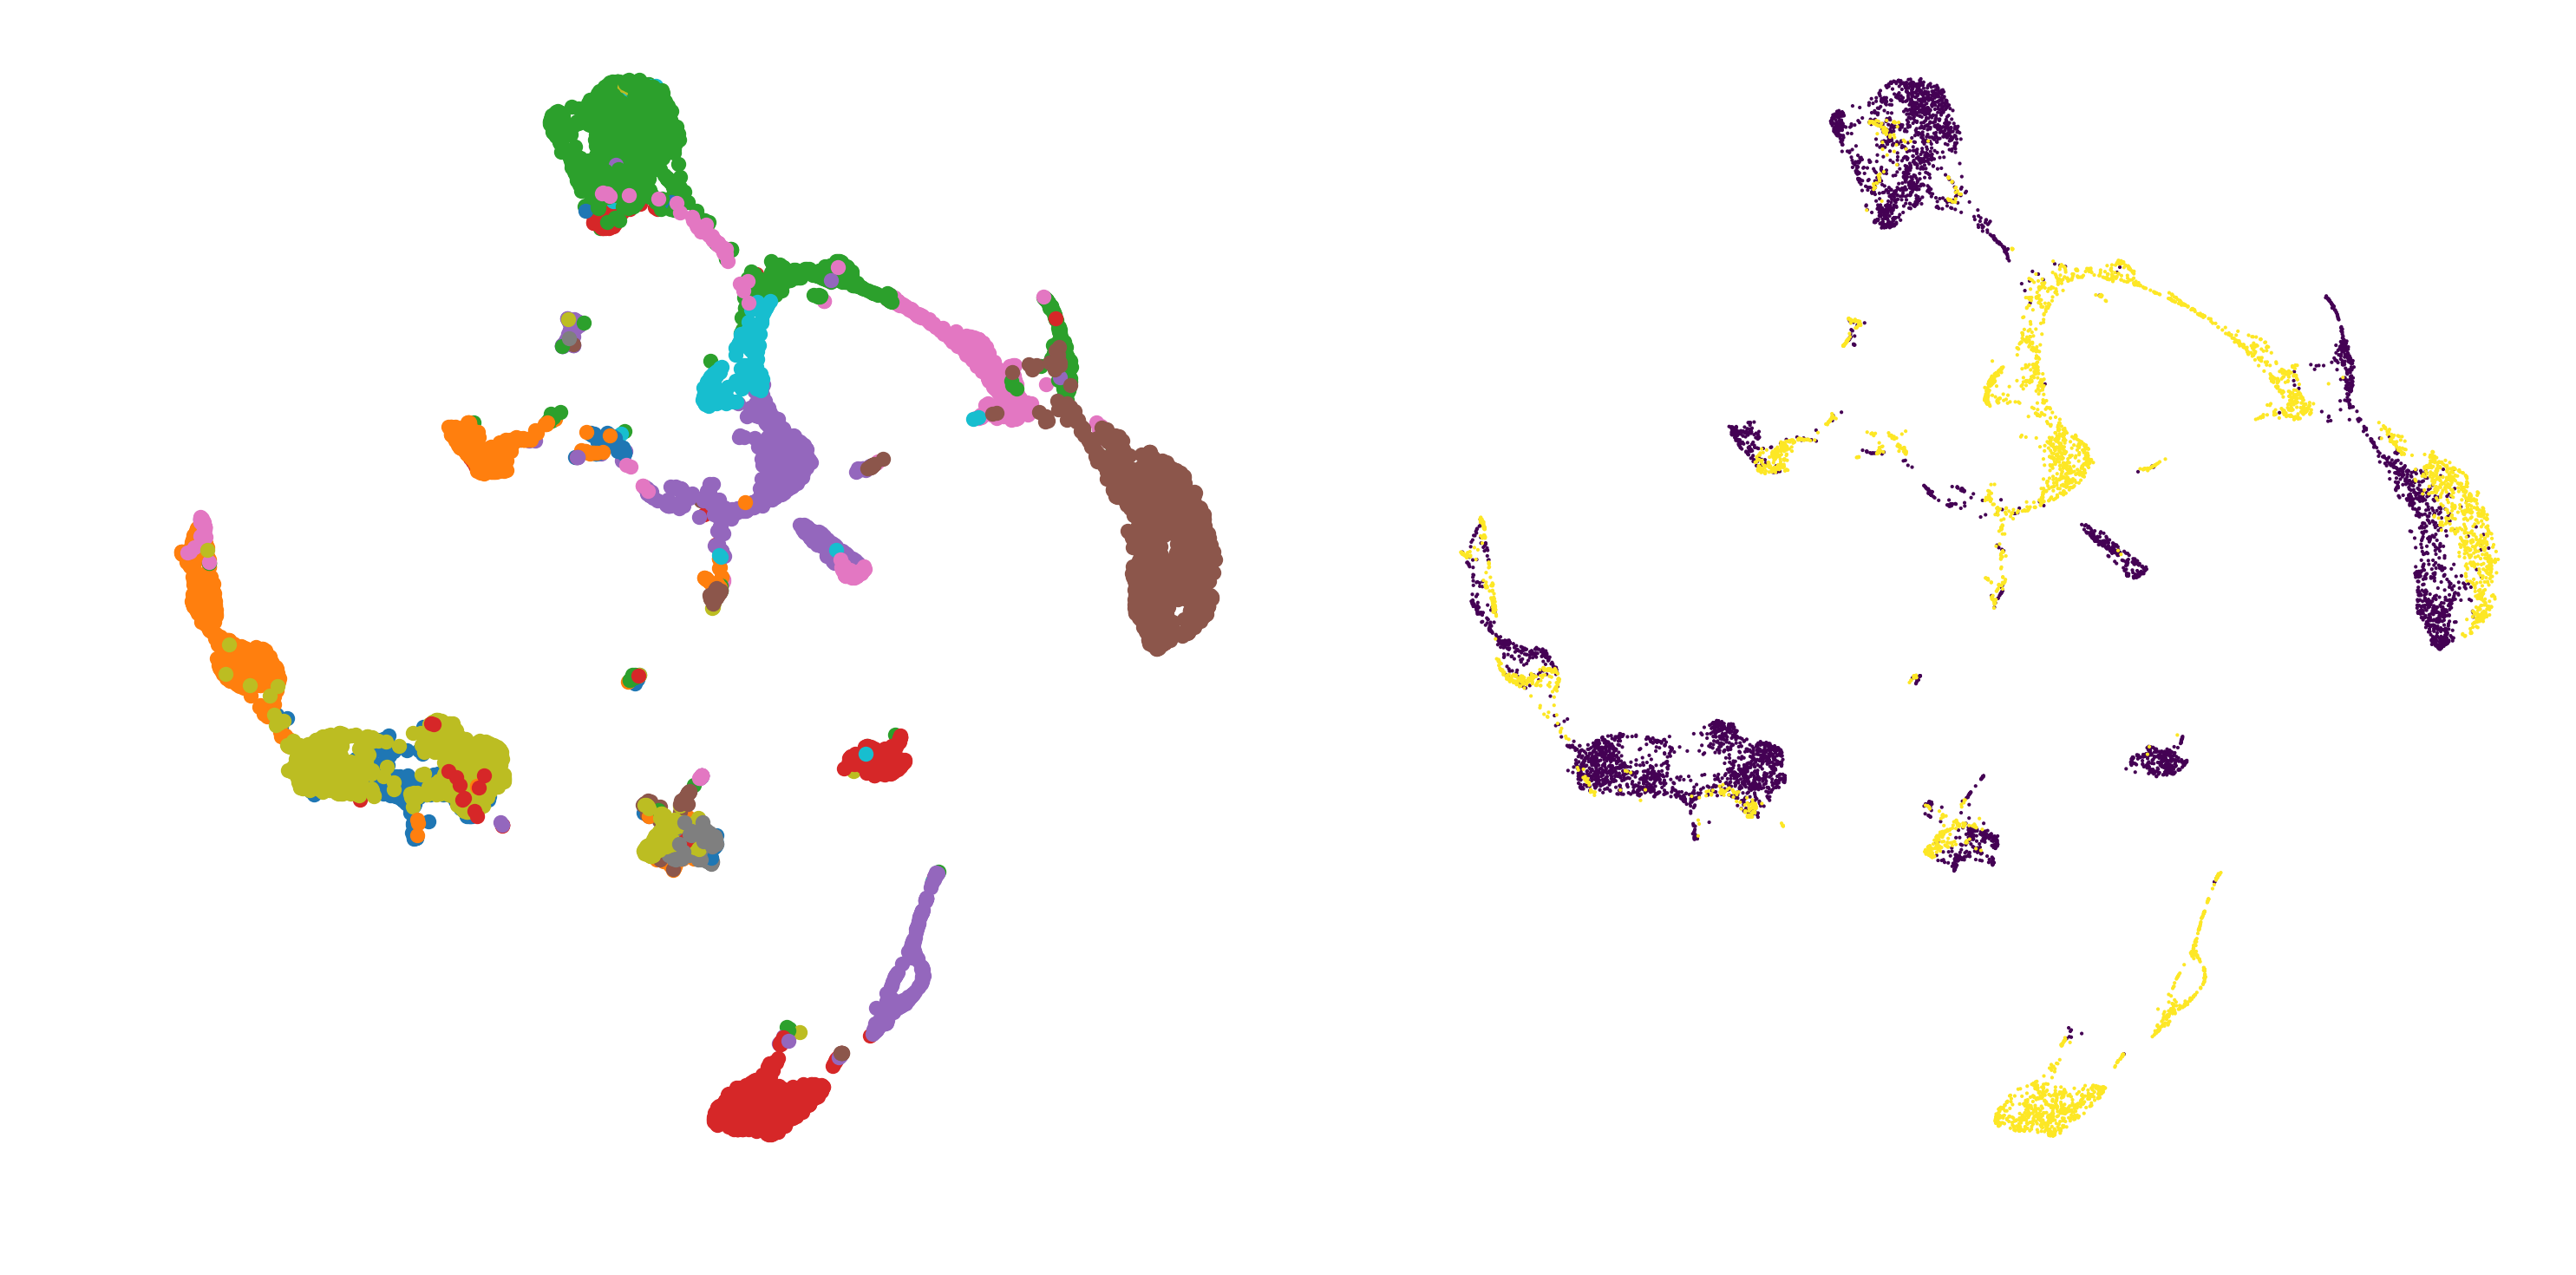

In [64]:
latent, batch_indices, labels = full_nb2.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
# plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

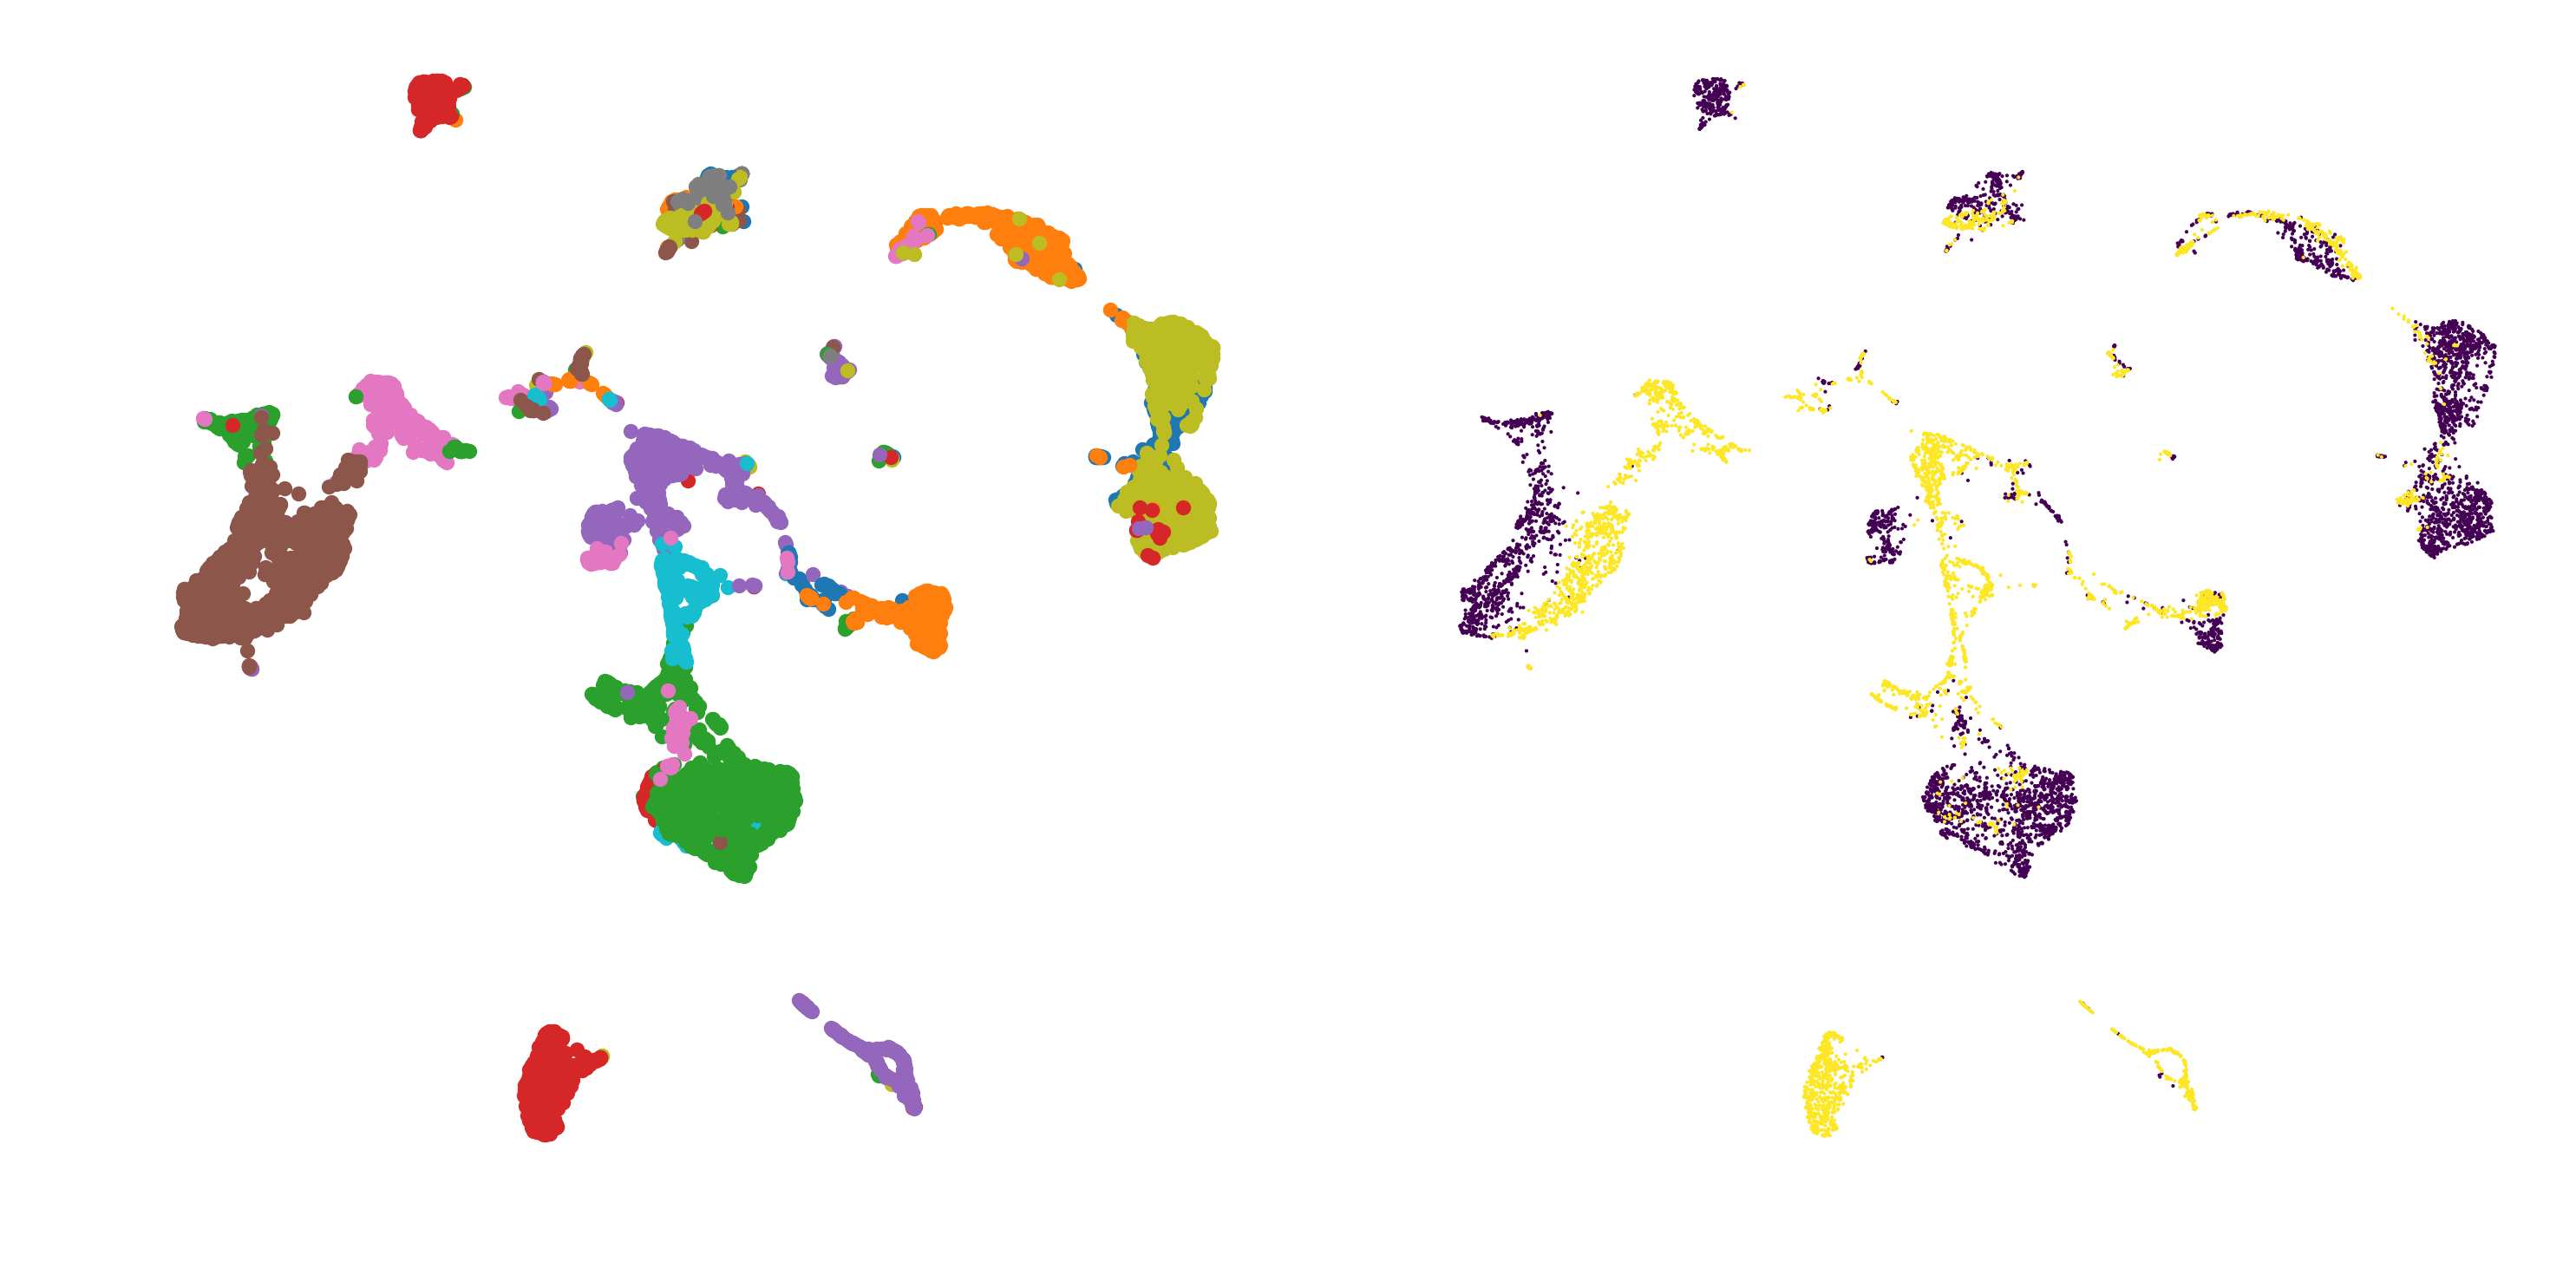

In [94]:
latent, batch_indices, labels = full_nb.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
# plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

In [84]:
full_zinb.ll()

2339.8371420268413

In [85]:
full_zinb2.ll()

2349.2038003275916

In [86]:
full_nb.ll()

2531.33982022086

In [87]:
full_nb2.ll()

2544.149179699884

In [71]:
np.mean(cellsize[batch_indices.ravel()==0])

324.5215277746125

In [72]:
np.mean(cellsize[batch_indices.ravel()==1])

4.0962800456400394

In [107]:
full_nb.gene_dataset.local_means

array([[12.622438],
       [12.622438],
       [12.622438],
       ...,
       [ 8.719   ],
       [ 8.719   ],
       [ 8.719   ]], dtype=float32)

In [95]:
from scvi.inference.posterior import entropy_batch_mixing
from scvi.metrics.clustering import select_indices_evenly


In [114]:
gene_dataset.X.shape

(9463, 1804)

In [115]:
np.unique(batch_indices[sample],return_counts=True)

(array([0, 1]), array([2000, 2000]))

In [ ]:
batch_indices[sample]

In [120]:
latent, batch_indices, labels = full_nb.sequential().get_latent()
sample = select_indices_evenly(2000, batch_indices)
batch_entropy = entropy_batch_mixing(latent[sample, :], batch_indices[sample],
                                     n_neighbors=200,n_samples_per_pool=500)
batch_entropy

0.4303314754558062

In [121]:
latent, batch_indices, labels = full_nb2.sequential().get_latent()
sample = select_indices_evenly(2000, batch_indices)
batch_entropy = entropy_batch_mixing(latent[sample, :], batch_indices[sample],
                                     n_neighbors=200,n_samples_per_pool=500)
batch_entropy

0.4207381953515832

In [122]:
latent, batch_indices, labels = full_zinb.sequential().get_latent()
sample = select_indices_evenly(2000, batch_indices)
batch_entropy = entropy_batch_mixing(latent[sample, :], batch_indices[sample],
                                     n_neighbors=200,n_samples_per_pool=500)
batch_entropy

0.4655597234822315

In [123]:
latent, batch_indices, labels = full_zinb2.sequential().get_latent()
sample = select_indices_evenly(2000, batch_indices)
batch_entropy = entropy_batch_mixing(latent[sample, :], batch_indices[sample],
                                     n_neighbors=200,n_samples_per_pool=500)
batch_entropy

0.4655817525372256